Wake direction (from label): 32.5°
📏 Radon vs Label Angle Error: 32.54°


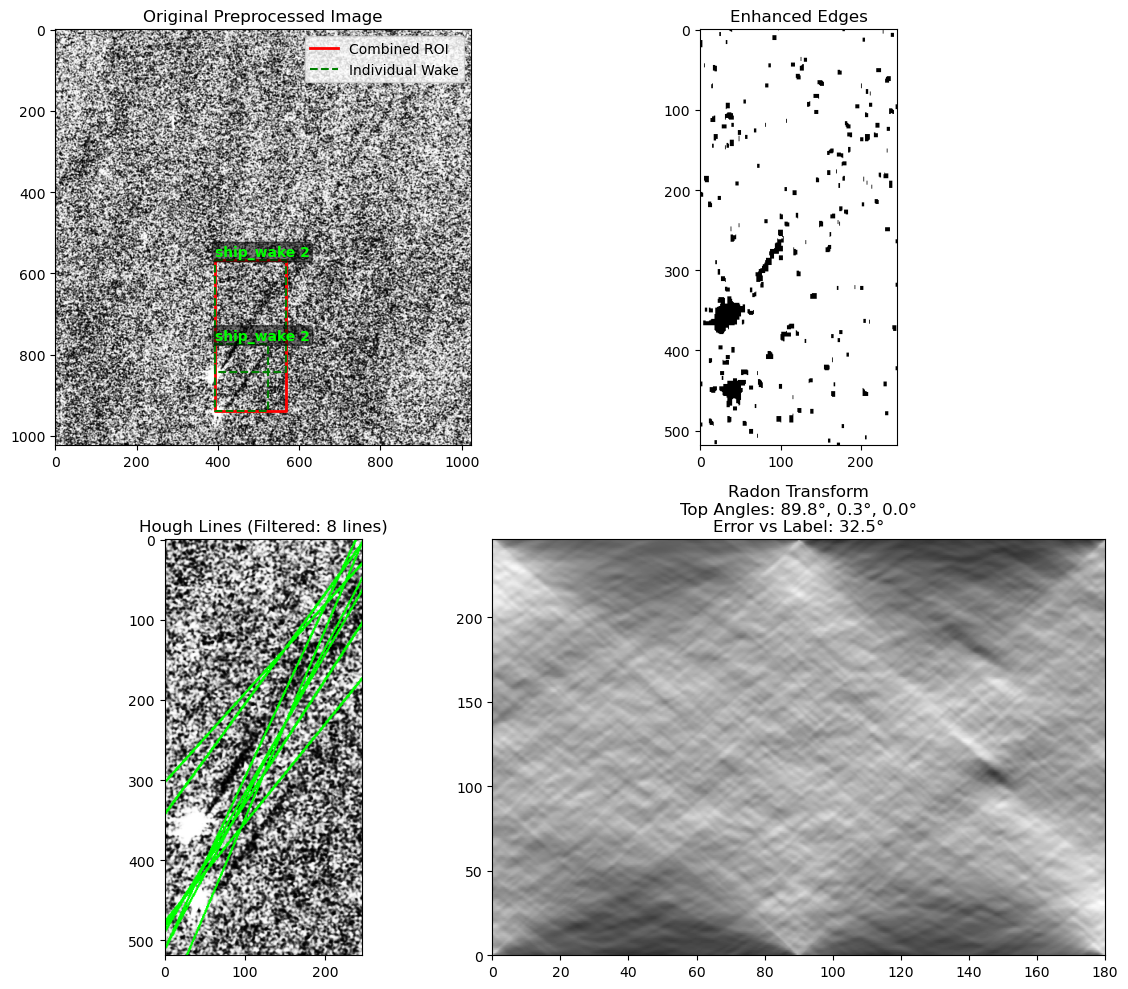

In [29]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.transform import radon
from math import atan2, degrees, cos, sin

# Load annotation from .txt 
def load_wake_annotations(txt_path):
    """
    Load ship wake annotations from a text file.
    
    Args:
        txt_path (str): Path to the annotation text file
        
    Returns:
        list: List of dictionaries containing wake coordinates and labels
              Each dictionary has 'coords' (list of 8 floats representing 4 points)
              and 'label' (string identifier for the wake)
    """
    wake_coords = []  # Initialize empty list to store wake coordinates and labels
    with open(txt_path, 'r') as f:
        for line in f:
            parts = line.strip().split()  # Split line into parts
            if len(parts) < 9:
                continue  # Skip incomplete lines that don't have enough coordinates + label
            coords = list(map(float, parts[:8]))  # Extract 4 points (x1,y1,...x4,y4) and convert to float
            label = parts[-2] + " " + parts[-1]   # Combine last two parts for label (e.g., 'ship_wake 0')
            wake_coords.append({
                'coords': coords,
                'label': label
            })
    return wake_coords
# Image & annotation input
img_path = r"D:\Master Project\Opensarwake\OpenSARWake_1.0\test\images\36.png"
label_path = r"D:\Master Project\Opensarwake\OpenSARWake_1.0\test\labels\36.txt"

# Load the grayscale image from the specified path
img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
# Load wake annotations from the label file
wake_coords = load_wake_annotations(label_path)

# Preprocessing
# Apply Gaussian blur to reduce noise (5x5 kernel)
img_blur = cv2.GaussianBlur(img, (5, 5), 0)
# Apply histogram equalization to enhance contrast
img_eq = cv2.equalizeHist(img_blur)

# Calculate the average angle of wake directions from the label data
label_angles = []
for wake in wake_coords:
    coords = wake['coords']
    # Extract the first two points from coordinates
    x1, y1, x2, y2 = coords[:4]
    # Calculate angle in degrees using arctangent
    angle = degrees(atan2(y2 - y1, x2 - x1))
    # Normalize angle to be between 0 and 180 degrees
    if angle < 0:
        angle += 180
    label_angles.append(angle)

# Calculate the mean angle from all wake directions
label_angle = np.mean(label_angles)
print(f"Wake direction (from label): {label_angle:.1f}°")

# Combined ROI extraction
# Concatenate all wake coordinates into a single array
all_points = np.concatenate([np.array(w['coords']).reshape(-1, 2) for w in wake_coords], axis=0)
# Find the minimum and maximum x,y coordinates to create a bounding box
x_min, y_min = np.min(all_points, axis=0)
x_max, y_max = np.max(all_points, axis=0)

# Add margins around the bounding box (20% of width and height)
margin_x = int((x_max - x_min) * 0.2)
margin_y = int((y_max - y_min) * 0.2)

# Extract the Region of Interest (ROI) from the equalized image
# Ensure the ROI stays within image boundaries
roi = img_eq[
    max(0, int(y_min) - margin_y): min(img.shape[0], int(y_max) + margin_y),
    max(0, int(x_min) - margin_x): min(img.shape[1], int(x_max) + margin_x)
]

# Edge Detection & Morphology 
# Calculate threshold values for Canny edge detection using median-based approach
v = np.median(roi)
sigma = 0.33
lower = int(max(0, (1.0 - sigma) * v))  # Lower threshold for Canny
upper = int(min(255, (1.0 + sigma) * v))  # Upper threshold for Canny
edges = cv2.Canny(roi, lower, upper)  # Apply Canny edge detection

# Define horizontal and vertical kernels for morphological operations
kernel_h = np.ones((1, 5), np.uint8)  # Horizontal kernel (1×5)
kernel_v = np.ones((5, 1), np.uint8)  # Vertical kernel (5×1)
# Apply morphological closing to connect nearby edges
edges_morph = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel_h)  # Close horizontal gaps
edges_morph = cv2.morphologyEx(edges_morph, cv2.MORPH_CLOSE, kernel_v)  # Close vertical gaps

# Hough Transform - Detect lines in the edge-detected image
lines = cv2.HoughLines(edges_morph, 1, np.pi / 180, threshold=30)  # Parameters: image, rho resolution, theta resolution, threshold
roi_color = cv2.cvtColor(roi, cv2.COLOR_GRAY2BGR)  # Convert ROI to color for visualization

# Limit the number of lines to draw for clarity
max_drawn = 30  # Maximum number of lines to draw
drawn_count = 0  # Counter for drawn lines
drawn_angles = []  # Track angles already drawn to avoid duplicates
angle_margin = 10  # Acceptable angle difference from label_angle (in degrees)

if lines is not None:
    for line in lines:
        rho, theta = line[0]  # Extract line parameters (rho: distance, theta: angle)
        theta_deg = degrees(theta)  # Convert angle from radians to degrees

        # Only draw lines that are close to the labeled angle (or its 180° complement)
        if abs(theta_deg - label_angle) < angle_margin or abs(theta_deg - (label_angle + 180)) < angle_margin:
            # Skip if we already drew a line with a very similar angle (within 2 degrees)
            if any(abs(theta_deg - a) < 2 for a in drawn_angles):
                continue
            drawn_angles.append(theta_deg)  # Add this angle to our tracking list
            drawn_count += 1  # Increment counter
            if drawn_count > max_drawn:  # Stop if we've drawn enough lines
                break

            # Calculate line endpoints using parametric form
            # x = x0 + t*(-b), y = y0 + t*(a) where (x0,y0) is point on line closest to origin
            a = cos(theta)
            b = sin(theta)
            x0 = a * rho
            y0 = b * rho
            
            # Calculate endpoints by extending 1000 pixels in both directions
            x1 = int(x0 + 1000 * (-b))
            y1 = int(y0 + 1000 * (a))
            x2 = int(x0 - 1000 * (-b))
            y2 = int(y0 - 1000 * (a))
            
            # Draw the line on the color ROI image
            cv2.line(roi_color, (x1, y1), (x2, y2), (0, 255, 0), 2)  # Green line with thickness 2
#  Radon Transform 
# Create an array of angles from 0 to 180 degrees for the Radon transform
# Number of angles equals the maximum dimension of the ROI for adequate sampling
theta = np.linspace(0., 180., max(roi.shape), endpoint=False)

# Apply the Radon transform to the ROI image
# This creates a sinogram where each column represents projections at a specific angle
sinogram = radon(roi, theta=theta)

# Calculate the mean projection value for each angle
# Higher values indicate stronger linear features at that angle
mean_proj = np.mean(sinogram, axis=0)

# Find the indices of the top 3 angles with highest mean projection values
# These represent the dominant orientations in the image
top_angles_idx = np.argsort(mean_proj)[-3:]

# Get the actual angle values corresponding to these indices
main_angles = theta[top_angles_idx]

# Select the angle with the highest projection value as the main orientation
radon_main = main_angles[-1]

# Calculate the error between the Radon-detected angle and the labeled angle
angle_error = abs(radon_main - label_angle)

# Adjust the error for angles that differ by more than 90 degrees
# This handles the case where angles like 170° and 10° are actually only 20° apart
if angle_error > 90:
    angle_error = 180 - angle_error

# Display the angle error between Radon transform result and the labeled angle
print(f"📏 Radon vs Label Angle Error: {angle_error:.2f}°")

# Create a 2x2 grid of subplots for visualization
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Display the preprocessed image in the top-left subplot
axs[0, 0].imshow(img_eq, cmap='gray')
axs[0, 0].set_title("Original Preprocessed Image")

# Draw the combined region of interest as a red rectangle
axs[0, 0].plot([x_min, x_max, x_max, x_min, x_min],
               [y_min, y_min, y_max, y_max, y_min], 'r-', linewidth=2, label='Combined ROI')
# Iterate through each wake coordinate set to draw bounding boxes and labels
for i, wake in enumerate(wake_coords):
    coords = wake['coords']  # Get the coordinates for this wake
    label = wake['label']    # Get the label (angle) for this wake
    # Convert coordinates to a numpy array and reshape to a list of points
    points = np.array(coords).reshape(-1, 2)
    # Find the minimum and maximum x,y coordinates to create a bounding box
    x1, y1 = np.min(points, axis=0)
    x2, y2 = np.max(points, axis=0)

    # Draw a green dashed rectangle for the wake bounding box
    # Only add to legend for the first wake to avoid duplicate legend entries
    axs[0, 0].plot([x1, x2, x2, x1, x1],
                   [y1, y1, y2, y2, y1], 'g--', linewidth=1.5,
                   label='Individual Wake' if i == 0 else None)

    # Add a text label showing the wake angle with a semi-transparent background
    axs[0, 0].text(x1, y1 - 10, f"{label}",
                   color='lime', fontsize=10, weight='bold',
                   bbox=dict(facecolor='black', alpha=0.5, boxstyle='round,pad=0.2'))

# Add a legend to the top-right corner of the first subplot
axs[0, 0].legend(loc='upper right')

# Display the enhanced edge image in the top-right subplot
axs[0, 1].imshow(edges_morph, cmap='gray')
axs[0, 1].set_title("Enhanced Edges")

# Display the region of interest with detected Hough lines in the bottom-left subplot
axs[1, 0].imshow(roi_color)
axs[1, 0].set_title(f"Hough Lines (Filtered: {drawn_count} lines)")

# Display the Radon transform sinogram in the bottom-right subplot
# aspect='auto' adjusts the aspect ratio, extent defines the x and y axis ranges
axs[1, 1].imshow(sinogram, cmap='gray', aspect='auto', extent=(0, 180, 0, sinogram.shape[0]))
# Add a title showing the detected angles and error compared to the labeled angle
axs[1, 1].set_title(f"Radon Transform\nTop Angles: {', '.join(f'{a:.1f}°' for a in main_angles)}\n"
                    f"Error vs Label: {angle_error:.1f}°")

# Adjust spacing between subplots for better appearance
plt.tight_layout()
# Display the complete figure with all subplots
plt.show()


